In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Least Squares Approximation

The idea here is that we are trying to load each known trajectory into a least squares approximation.

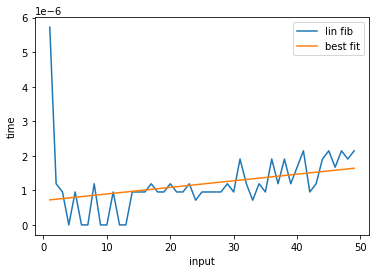

In [6]:
# create sample data
# linear time fib function
def fib(n):
  a, b = 0, 1
  for _ in range(n):
    a, b = b, a + b
  return a

# timer function
def timer(func, inp):
  start = time.time()
  func(inp)
  return time.time() - start

x = np.arange(1, 50)
y = np.array([timer(fib, i) for i in x])
a, b = np.polyfit(x, y, 1)

# plot the data and best fit
plt.plot(x, y, label="lin fib")
plt.plot(x, a*x + b, label="best fit")
plt.xlabel("input")
plt.ylabel("time")
plt.legend()
plt.show()

## attempt #1: each tracjectory seperated into seperate term

Each recorded time $y_i$ will be represented by $a+bx_i+cx^2_i+dx^3_i+elog(x_i)+fx_ilog(x_i)+g2^{x_i}$

In [7]:
# define functions
FXS = {
  "$1$": lambda x: 1,
  "$x$": lambda x: x,
  "$x^2$": lambda x: x**2,
  "$x^3$": lambda x: x**3,
  "$log(x)$": lambda x: np.log(x),
  "$xlog(x)$": lambda x: x*np.log(x),
  "$2^x$": lambda x: 2**x
}

# solves the least squares problem
# where every known trajectory is a function of the input
# and best fit represent the whichever coefficient is most optimal
# TODO: experiment with orthonormal regression
def solve_1(x, y):
  # assemble data matrix
  data = []
  for a in x:
    measurements = []
    for v in FXS.values():
      measurements.append(v(a))
    data.append(measurements)
  data = np.array(data)
  print(f"constucted data matrix with shape {data.shape}")

  # solve for coefficients
  coeffs = np.linalg.lstsq(data, y, rcond=None)[0]
  print(f"found coefficients {coeffs}")

  # find corresponding best fit
  func_num = np.argmax(coeffs)
  return func_num, coeffs[func_num]


constucted data matrix with shape (49, 7)
found coefficients [ 3.18354457e-09  2.10123051e-08 -4.87774736e-09  5.51186072e-11
  6.46019564e-09  3.32776088e-08 -1.17619879e-22]
best fit: $xlog(x)$


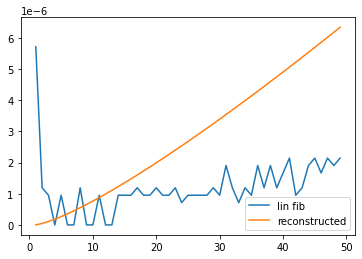

In [8]:
# solve for best fit
func_num, coeff = solve(x, y)
print(f"best fit: {list(FXS.keys())[func_num]}")
func = list(FXS.values())[func_num]
new_func = lambda x: coeff*func(x)

# plot reconstructed function and original
plt.plot(x, y, label="lin fib")
plt.plot(x, [new_func(i) for i in x], label="reconstructed")
plt.legend()
plt.show()


### validate data with a exponential runtime function

constucted data matrix with shape (39, 7)
found coefficients [ 6.04664728e+00 -6.00733506e+00 -1.39504892e-01  1.42141784e-03
  4.89380655e+00  2.40102235e+00  2.63963765e-11]
best fit: $1$


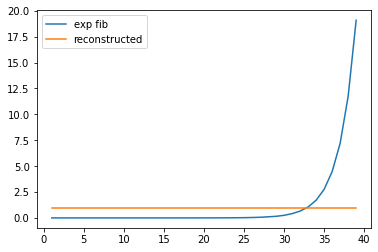

In [9]:
def fib_exp(n):
  if n < 2:
    return n
  else:
    return fib_exp(n-1) + fib_exp(n-2)

# solve
x = np.arange(1, 40)
# y = np.array([timer(fib_exp, i) for i in x])
# func_num, coeff = solve_1(x, y)
new_func_name = list(FXS.keys())[func_num]
new_func = FXS[new_func_name]
print(f"best fit: {new_func_name}")

# plot reconstructed function and original
plt.plot(x, y, label="exp fib")
plt.plot(x, [new_func(i) for i in x], label="reconstructed")
plt.legend()
plt.show()

**TLDR** this is not working. The problem is that some coefficients from previous terms seem to affect other terms. We need to solve seperate regressions for each known trajectory and return the one with the smallest loss.

## attempt #2: solving individual lst sqr problems for every trajectory 

In [20]:
# take each known trajectory and find a best fit for each one
# find total error for each trajectory
# return the trajectory with the lowest error
def solve_2(x, y):
  total_loss, coeffs = [], []
  for func in FXS.values():
    # find best fit via least squares
    coeff = np.linalg.lstsq(np.array([func(i) for i in x]).reshape(-1, 1), y, rcond=None)[0]
    coeffs.append(coeff)
    # find total loss
    loss = np.sum(np.abs(y - coeff*func(x)))
    total_loss.append(loss)
  # find best fit
  print(f"found total loss {total_loss}")
  func_num = np.argmin(total_loss)
  return func_num, coeffs[func_num]

found total loss [0.00010474522908528647, 4.578586472066473e-05, 8.11048478566683e-05, 0.00010948208241286795, 7.186573124606745e-05, 5.426733878916823e-05, 0.0002346038818359375]
best fit: $x$


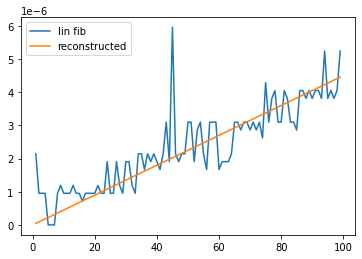

In [21]:
# create data
x = np.arange(1, 100)
y = np.array([timer(fib, i) for i in x])

# solve for best fit
func_num, coeff = solve_2(x, y)
print(f"best fit: {list(FXS.keys())[func_num]}")
func = list(FXS.values())[func_num]
new_func = lambda x: coeff*func(x)

# plot reconstructed function and original
plt.plot(x, y, label="lin fib")
plt.plot(x, [new_func(i) for i in x], label="reconstructed")
plt.legend()
plt.show()

## **SUCCESS**